<a href="https://colab.research.google.com/github/unkush-garg/FBI-Gun-Sales-data-analysis-in-python/blob/master/notebooks/phase2/Reason_for_joining_platoon_counts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install bertopic
!pip install fuzzywuzzy

     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 13.2 MB 8.4 MB/s 
     |████████████████████████████████| 80 kB 12.1 MB/s 
     |████████████████████████████████| 15.7 MB 331 kB/s 
     |████████████████████████████████| 6.4 MB 32.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 6.0 MB/s 
     |████████████████████████████████| 2.6 MB 53.0 MB/s 
     |████████████████████████████████| 1.2 MB 32.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 895 kB 36.7 MB/s 
     |████████████████████████████████| 636 kB 38.9 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.6 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311892 sha256=080d247570a66f62099f713a4e

In [4]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [14]:
# Bert
from bertopic import BERTopic
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 0)

In [126]:
phase_1_data = pd.read_csv('/content/drive/MyDrive/tradoc/datasets/report_1_data_clusters_with_data_that_Jeremy_rescued.csv')
phase_1_data = phase_1_data.replace(np.nan, "")

phase_2_data = pd.read_csv('/content/drive/MyDrive/tradoc/datasets/person_problem_with_problems_and_responses_session_2_with_platoon_etc_imputed.csv')
phase_2_data = phase_2_data.replace(np.nan, "")

model = BERTopic.load("/content/drive/MyDrive/tradoc/models/reason_to_join_model_3.pkl")

topics_df = pd.read_csv("/content/drive/MyDrive/tradoc/datasets/reason_to_join_topics_3.csv")


In [127]:
# Potential clusters and their descriptions
reason_for_joining_mapper = {
    0: "career",
    1: "had someone in the family",
    2: "for family",
    3: "n/a",
    4: "money",
    5: "serve the country",
    6: "better future",
    7: "did not want to go to college",
    8: "educational benefits",
}

In [128]:
topics_in_text = [reason_for_joining_mapper.get(topic) for topic in topics_df['cluster'].tolist()]

phase_1_data['reason_for_joining_text'] = topics_in_text
phase_1_data['reason_for_joining_cluster'] = topics_df['cluster']

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text major ticklabel objects>)

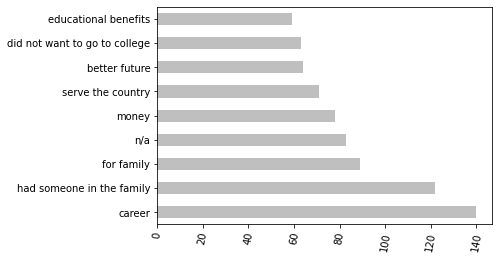

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
phase_1_data['reason_for_joining_text'].value_counts().plot(kind='barh', color='grey', alpha=0.5)

plt.xticks(rotation=80)

In [173]:
topic_cluster_and_reason_for_joining_counts_df = phase_1_data.groupby(['cluster','reason_for_joining_text'], as_index=False)['mos'].count()


In [131]:
# for a topic, list the original statements that are applicable

def given_a_topic_list_original_statements(dataframe ,topic_number: int):
   return dataframe[dataframe['reason_for_joining_cluster'] == topic_number]

In [132]:
# Analyze clusters and reason to join
# Anything intersting between recruits who joined for better career prospects?

career_as_a_reason_for_joining = given_a_topic_list_original_statements(phase_1_data, 0)

### Model phase 2

In [133]:
phase_2_data.sample(3)

,person_id,platoon,mos,company,phone,name,home_town,birth_year,problem,background,title,basic_need,basic_need_detail,solution,solution_detail,reason_for_joining
714,6050,1st Platoon,25 Bravo,Echo Company,17035684550,,,2003,Make the Jacob's tower not a requirement,That ladder is really scary and had me freaking out the whole time climbing,If youre scared of heights be careful about the Jacob's tower,Maybe to test how you do under pressure,Nothing really to fix except giving us a harness,Maybe fix the wood,"Yknow, replace the wood with fresh ones so others don't get splinters",
146,6317,3rd Platoon,15C,Alpha Company,14175225528,Toxey,Missouri,2003,Nothing,Not really,There is nothing to change,Idk since there's nothing to change,There ain't nothin,I wouldn't since it's fine,It just would,I wanted to become a pilot
619,6610,3rd Platoon,I decided on 91 bravo,Delta Company,12087921162,,,2002,,,,,,,,


In [134]:
phase_2_data['problems_and_background'] = phase_2_data['problem'] + " " + phase_2_data['background']

docs = []
columns = ["problems_and_background"]

for column in columns:
    column_to_list = phase_2_data[column].tolist()
    column_to_list = [doc.lower().strip() for doc in column_to_list]
    columns_to_list = [doc for doc in column_to_list if doc != '']
    docs.extend(column_to_list)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer

phase_2_model = BERTopic(
    # top_n_words=5,
    nr_topics=15,
    # min_topic_size=15,
    n_gram_range=(2, 5),
    calculate_probabilities=True,
    vectorizer_model=CountVectorizer(analyzer='word', ngram_range=(2, 5))
    )

phase_2_topics = phase_2_model.fit_transform(docs)



In [135]:
phase_2_data['clusters'] = phase_2_topics[0]

In [136]:
phase_2_data.sample(3)

,person_id,platoon,mos,company,phone,name,home_town,birth_year,problem,background,title,basic_need,basic_need_detail,solution,solution_detail,reason_for_joining,problems_and_background,clusters
1034,6185,2nd Platoon,91Bravo,Charlie Company,18083338025,,,2002,,,,,,,,,,0
275,6662,4th Platoon,25 Quebec,Bravo Company,13862354239,Sweeny,Deland Florida,2002,Showers and intense training,The heat is very intense for some people,So much physical activity without enough recovery time is a lot,Not enough rest time,Stop pushing trainees to the point of injury,Allowing small breaks and for trainees to have cold drinking water,Helping keep trainees hydrated with colder drinking water will help regulate body temperature,Always wanted to,Showers and intense training The heat is very intense for some people,-1
466,6596,2nd Platoon,15U,Delta Company,14847587269,Joshua Ayres,124 Mount Hope road Lincoln University PA,2002,Nothing,There's not much to change,Red phase is fine,Good things,There's nothing to fix,There isn't anything to fix,Do nothing,A good future/ career,Nothing There's not much to change,-1


Text(0.5, 0, 'Problem topics')

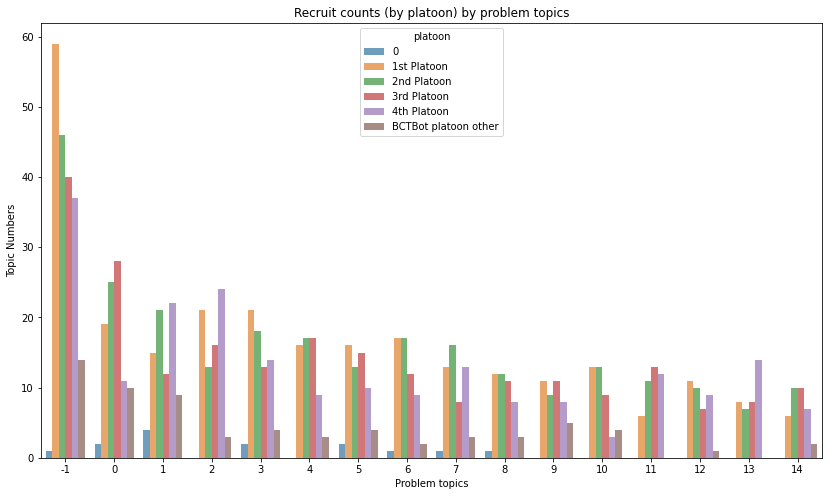

In [138]:
problem_topics_grouped = phase_2_data.groupby(['clusters','platoon'], as_index=False).count()[['clusters', 'platoon', 'mos']]
problem_topics_grouped = problem_topics_grouped.replace('', np.NaN)
problem_topics_grouped = problem_topics_grouped.dropna()


fig, axes = plt.subplots(1, 1, figsize=(14, 8))
sns.barplot(x="clusters", 
            y="mos", 
            hue="platoon", 
            data=problem_topics_grouped, alpha=0.7)

plt.title("Recruit counts (by platoon) by problem topics")
plt.ylabel("Topic Numbers")
plt.xlabel("Problem topics")

Text(0.5, 0, 'Problem topics')

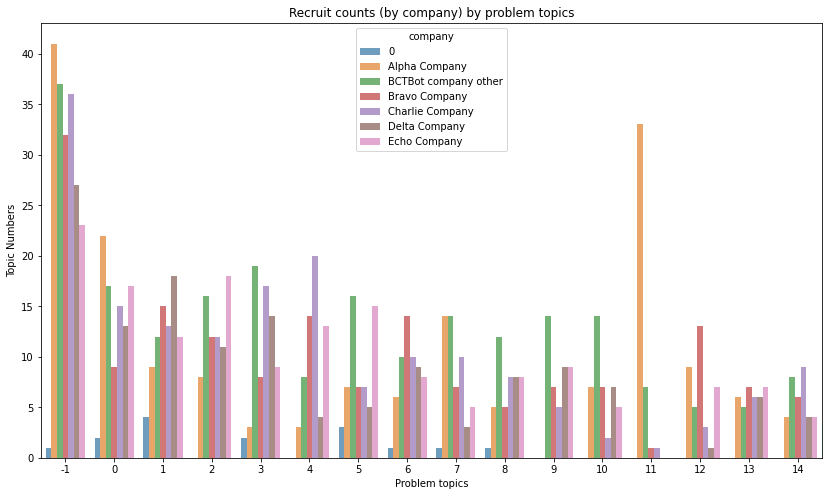

In [141]:
problem_topics_grouped_by_company = phase_2_data.groupby(['clusters','company'], as_index=False).count()[['clusters', 'company', 'mos']]
problem_topics_grouped_by_company = problem_topics_grouped_by_company.replace('', np.NaN)
problem_topics_grouped_by_company = problem_topics_grouped_by_company.dropna()


fig, axes = plt.subplots(1, 1, figsize=(14, 8))
sns.barplot(x="clusters", 
            y="mos", 
            hue="company", 
            data=problem_topics_grouped_by_company, alpha=0.7)

plt.title("Recruit counts (by company) by problem topics")
plt.ylabel("Topic Numbers")
plt.xlabel("Problem topics")

In [168]:
cluster_number = 0

platoon_counts_by_cluster = {}

for cluster_number in phase_1_data['cluster'].unique():
    platoon_counts = phase_1_data[phase_1_data['cluster'] == cluster_number]['platoon'].value_counts().to_json()
    platoon_counts_by_cluster["cluster_number_" + str(cluster_number)] = [platoon_counts]


    platoon_counts_by_cluster["cluster_number_" + str(cluster_number)].append({'total_number_of_people_in_the_cluster': len(phase_1_data[phase_1_data['cluster'] == cluster_number])})
    platoon_counts_by_cluster["cluster_number_" + str(cluster_number)].append({'total_number_of_people': phase_1_data.shape[0]})
